In [9]:
#import packages & libraries
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
from datetime import datetime

end_date = "2020-12-31"
dt = datetime.strptime(end_date, "%Y-%m-%d")
unix_timestamp_end = int(dt.timestamp())
print(unix_timestamp_end)

1609372800


In [13]:
import requests

url = 'https://api.blockchain.info/charts/market-price?timespan=all&format=json'
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    # do something with the data
else:
    print('Failed to retrieve data from the API endpoint.')


In [14]:
print(len(data['values']))


1726


In [16]:
def daily_price_historical(symbol, comparison_symbol, all_data=True, limit=1, aggregate=1, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    if all_data:
        url += '&allData=true'
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.fromtimestamp(d) for d in df.time]
    return df

In [17]:
df = daily_price_historical('BTC','USD')

df.head(10)
#df.tail(10)

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timestamp
0,1279324800,0.04951,0.04951,0.04951,20.00,0.9902,0.04951,direct,,2010-07-17
1,1279411200,0.08585,0.05941,0.04951,75.01,5.0920,0.08584,direct,,2010-07-18
2,1279497600,0.09307,0.07723,0.08584,574.00,49.6600,0.08080,direct,,2010-07-19
3,1279584000,0.08181,0.07426,0.08080,262.00,20.5900,0.07474,direct,,2010-07-20
4,1279670400,0.07921,0.06634,0.07474,575.00,42.2600,0.07921,direct,,2010-07-21
5,1279756800,0.08181,0.05050,0.07921,2160.00,129.7800,0.05050,direct,,2010-07-22
6,1279843200,0.06767,0.05050,0.05050,2402.50,141.0700,0.06262,direct,,2010-07-23
7,1279929600,0.06161,0.05049,0.06262,496.32,26.7300,0.05454,direct,,2010-07-24
8,1280016000,0.05941,0.05050,0.05454,1551.48,85.0600,0.05050,direct,,2010-07-25
9,1280102400,0.05600,0.05000,0.05050,877.00,46.9100,0.05600,direct,,2010-07-26


In [18]:
#rename columns
prophet_df = df.rename(columns={'timestamp':'ds',
                                'close':'y'})

#check
prophet_df.columns

Index(['time', 'high', 'low', 'open', 'volumefrom', 'volumeto', 'y',
       'conversionType', 'conversionSymbol', 'ds'],
      dtype='object')

In [17]:
all_days = []
all_prices = []
for val in data['values']:
    date_time = datetime.fromtimestamp(val['x'])
    # Convert datetime object to date object
    date = date_time.date()
    all_days.append(date)
    all_prices.append(val['y'])

all_dict = {'Date': all_days, 'Close': all_prices}  
       
all_df = pd.DataFrame(all_dict) 
data_filename = 'all_data.csv'
all_df.to_csv(data_filename, index=False) 

print(f"{data_filename} created successfully.")

all_data.csv created successfully.


In [18]:
days = []
prices = []
for val in data['values']:
    if val['x'] <= unix_timestamp_end:
        date_time = datetime.fromtimestamp(val['x'])
        # Convert datetime object to date object
        date = date_time.date()
        days.append(date)
        prices.append(val['y'])

dict = {'Date': days, 'Close': prices}  
       
df = pd.DataFrame(dict) 
filename = 'bitcoin_prices.csv'
df.to_csv(filename, index=False) 

print(f"{filename} created successfully.")

bitcoin_prices.csv created successfully.


In [19]:
df = pd.read_csv(filename)
df.head(10)

,Date,Close
0,2009-01-03,0.0
1,2009-01-06,0.0
2,2009-01-09,0.0
3,2009-01-12,0.0
4,2009-01-15,0.0
5,2009-01-18,0.0
6,2009-01-21,0.0
7,2009-01-24,0.0
8,2009-01-27,0.0
9,2009-01-30,0.0


In [24]:
df.tail(10)

,Date,Close
1451,2020-12-04,19454.54
1452,2020-12-07,19377.66
1453,2020-12-10,18554.15
1454,2020-12-13,18803.44
1455,2020-12-16,19439.75
1456,2020-12-19,23150.79
1457,2020-12-22,22745.48
1458,2020-12-25,23715.53
1459,2020-12-28,26246.58
1460,2020-12-31,28856.59


In [20]:
#rename columns
prophet_df = df.rename(columns={'Date':'ds',
                                'Close':'y'})

#check
prophet_df.columns

Index(['ds', 'y'], dtype='object')

In [21]:
#initialize
model = Prophet()

#fit
model.fit(prophet_df)

23:01:39 - cmdstanpy - INFO - Chain [1] start processing
23:01:39 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
#forecast for the next 30 days
future = model.make_future_dataframe(periods=365)

#predict
forecast = model.predict(future)
     

#check out forecast
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-01-03,-56.042961,-1548.962837,2838.956066,-56.042961,-56.042961,692.342998,692.342998,692.342998,-39.430816,-39.430816,-39.430816,731.773813,731.773813,731.773813,0.0,0.0,0.0,636.300037
1,2009-01-06,-55.581324,-1712.579593,2577.868943,-55.581324,-55.581324,536.985449,536.985449,536.985449,-12.819946,-12.819946,-12.819946,549.805395,549.805395,549.805395,0.0,0.0,0.0,481.404125
2,2009-01-09,-55.119688,-1951.355990,2784.387259,-55.119688,-55.119688,407.624540,407.624540,407.624540,31.242520,31.242520,31.242520,376.382020,376.382020,376.382020,0.0,0.0,0.0,352.504852
3,2009-01-12,-54.658052,-2130.195569,2327.632093,-54.658052,-54.658052,230.014497,230.014497,230.014497,6.970177,6.970177,6.970177,223.044319,223.044319,223.044319,0.0,0.0,0.0,175.356445
4,2009-01-15,-54.196416,-2024.398876,2407.671653,-54.196416,-54.196416,135.524491,135.524491,135.524491,39.061088,39.061088,39.061088,96.463403,96.463403,96.463403,0.0,0.0,0.0,81.328076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2021-12-27,14492.720754,13231.190307,17934.097147,13737.660937,15212.167517,1117.979444,1117.979444,1117.979444,6.970177,6.970177,6.970177,1111.009266,1111.009266,1111.009266,0.0,0.0,0.0,15610.700197
1822,2021-12-28,14499.355403,12988.598477,17824.112159,13737.766973,15220.880442,1056.895034,1056.895034,1056.895034,-12.819946,-12.819946,-12.819946,1069.714980,1069.714980,1069.714980,0.0,0.0,0.0,15556.250437
1823,2021-12-29,14505.990052,13238.159079,17941.667146,13737.873009,15230.211795,1013.474241,1013.474241,1013.474241,-10.399999,-10.399999,-10.399999,1023.874240,1023.874240,1023.874240,0.0,0.0,0.0,15519.464294
1824,2021-12-30,14512.624702,13114.640456,17956.711912,13737.979045,15241.378494,1013.098145,1013.098145,1013.098145,39.061088,39.061088,39.061088,974.037056,974.037056,974.037056,0.0,0.0,0.0,15525.722847


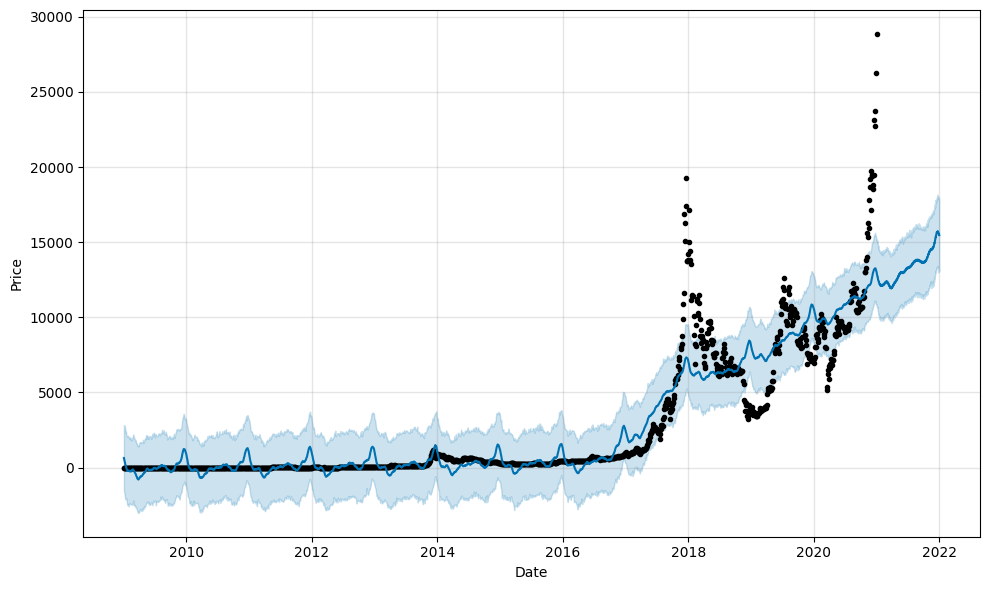

In [26]:
#visualize with Facebook internal tool
figure_1 = model.plot(forecast,
                    xlabel='Date',
                    ylabel='Price')

In [28]:
data = prophet_df[['ds','y']]
print(data)
data.dropna(inplace=True)
data.columns = ['ds', 'y'] 
data.head()

              ds         y
0     2009-01-03      0.00
1     2009-01-06      0.00
2     2009-01-09      0.00
3     2009-01-12      0.00
4     2009-01-15      0.00
...          ...       ...
1456  2020-12-19  23150.79
1457  2020-12-22  22745.48
1458  2020-12-25  23715.53
1459  2020-12-28  26246.58
1460  2020-12-31  28856.59

[1461 rows x 2 columns]


,ds,y
0,2009-01-03,0.0
1,2009-01-06,0.0
2,2009-01-09,0.0
3,2009-01-12,0.0
4,2009-01-15,0.0


In [19]:
from neuralprophet import NeuralProphet

m = NeuralProphet()
neural_model = m.fit(data, freq='D', epochs=200)
future = m.make_future_dataframe(data, periods=365)
forecast = m.predict(future)
forecast.head()

NameError: name 'data' is not defined

In [38]:
forecast.tail(10)

,ds,y,yhat1,trend,season_yearly,season_weekly
355,2021-12-22,None,14417.051758,13109.163086,1317.012939,-9.124310
356,2021-12-23,None,14442.665039,13114.028320,1302.017944,26.619186
357,2021-12-24,None,14448.688477,13118.893555,1283.161255,46.633160
358,2021-12-25,None,14345.208984,13123.759766,1260.483521,-39.033630
359,2021-12-26,None,14341.060547,13128.627930,1234.052490,-21.619806
360,2021-12-27,None,14340.116211,13133.496094,1203.962769,2.657368
361,2021-12-28,None,14302.564453,13138.361328,1170.334595,-6.131968
362,2021-12-29,None,14267.416992,13143.227539,1133.314331,-9.124310
363,2021-12-30,None,14267.785156,13148.092773,1093.072510,26.619186
364,2021-12-31,None,14249.397461,13152.960938,1049.803589,46.633160


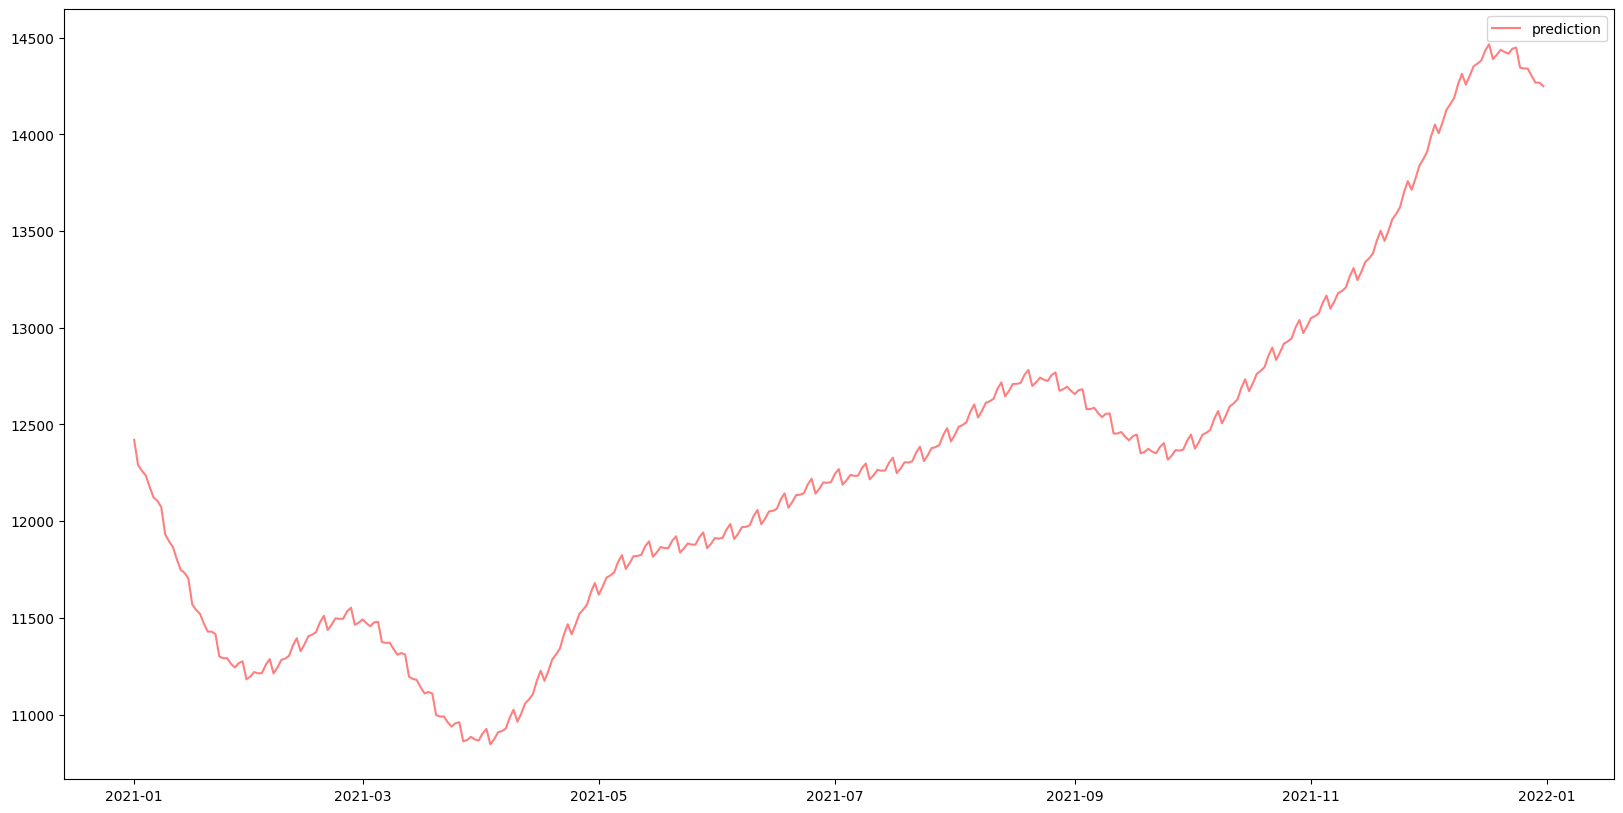

In [41]:
plt.figure(figsize=(20,10))
plt.plot(forecast['ds'], forecast['yhat1'],color='red',alpha=0.5, label="prediction")
plt.legend()
plt.show()